Using LSTM to make stock predictions, the usual

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset

putting some common tickers here  
AAPL, FB, AMZN, TSLA

In [2]:
# define hyperparamters

SEQ_LEN = 50

VAL_PCT = 0.2

HIDDEN_DIM = 64
N_LAYERS = 2
OUT_DIM = 1

EPOCHS = 4
BATCH_SIZE=128
LR = 0.0005

In [3]:
# gonna use the adjusted close to represent the price for the day

data = yf.download(tickers='AMZN', period='max', interval='1d')['Adj Close']
data

[*********************100%***********************]  1 of 1 completed


Date
1997-05-15       1.958333
1997-05-16       1.729167
1997-05-19       1.708333
1997-05-20       1.635417
1997-05-21       1.427083
                 ...     
2020-12-02    3203.530029
2020-12-03    3186.729980
2020-12-04    3162.580078
2020-12-07    3158.000000
2020-12-08    3177.290039
Name: Adj Close, Length: 5932, dtype: float64

<AxesSubplot:xlabel='Date'>

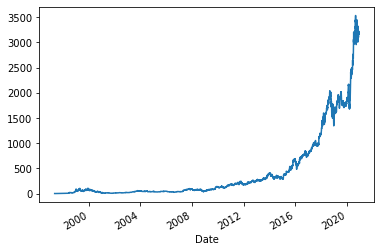

In [4]:
data.plot()

In [5]:
train_data = data.values

# scale all numbers between 0 and 1

scaler = MinMaxScaler(feature_range=(-1,1))
train_data = scaler.fit_transform(train_data.reshape(-1,1))

In [6]:
train = []

for i in range(len(train_data)-SEQ_LEN):
    train.append(train_data[i:i+SEQ_LEN])

# the last value of each sequence will be the Y of that sequence

X = [i[:-1] for i in train]
Y = [i[-1] for i in train]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=VAL_PCT)

X_train = np.array(X_train).squeeze()
X_test = np.array(X_test).squeeze()
Y_train = np.array(Y_train).squeeze()
Y_test = np.array(Y_test).squeeze()

X_train = torch.tensor(X_train).float().cuda()
Y_train = torch.tensor(Y_train).float().cuda()
X_test = torch.tensor(X_test).long().cuda()
Y_test = torch.tensor(Y_test).long().cuda()

In [7]:
train_set = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
class LSTM(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_layers, out_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(in_dim, hidden_dim, n_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, out_dim)
    
    def forward(self, x):
        x, h = self.lstm(x.view(len(x),1,-1))
        x = self.fc1(x)
        return x

In [9]:
model = LSTM(SEQ_LEN-1, HIDDEN_DIM, N_LAYERS, OUT_DIM).cuda()
optimizer = optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.MSELoss()

In [10]:
# training time!
losses = []

for epoch in range(EPOCHS):
    for X_batch, Y_batch in tqdm(train_loader):
        outputs = model(X_batch)
        loss = loss_fn(outputs, Y_batch)

        model.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss)

100%|██████████| 37/37 [00:00<00:00, 259.97it/s]


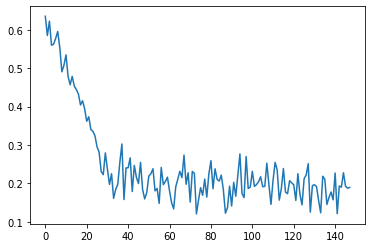

In [11]:
plt.plot(losses)

In [12]:
X = torch.tensor(X).cuda().float()

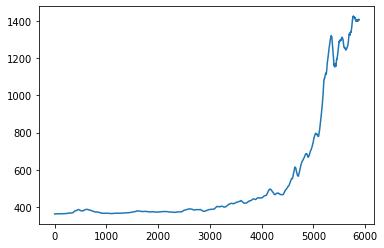

In [14]:
pred = scaler.inverse_transform(model(X).squeeze().cpu().detach().numpy().reshape(-1,1))

plt.plot(pred)

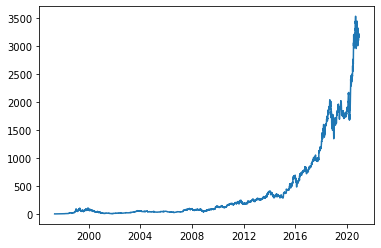

In [15]:
plt.plot(data)